# Import libraries

In [42]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import SEACells
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from dfply import *

# Load settings

In [43]:
from re import search

if search("BI2404M", os.uname()[1]):
    exec(open('/Users/argelagr/gastrulation10x/settings.py').read())
    exec(open('/Users/argelagr/gastrulation10x/utils.py').read())
else:
    exit("Computer not recognised")

## Define I/O

In [44]:
io["outdir"] = Path(io["basedir"]) / "results/metacells/trajectories/nmp"

## Define options 

In [45]:
# %%capture
# sc.settings.verbosity = 3
# sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(8, 7), facecolor='white')

In [46]:
opts["stages"] = [
#	"E6.5",
#	"E6.75",
#	"E7.0",
#	"E7.25",
	"E7.5",
	"E7.75",
	"E8.0",
	"E8.25",
	"E8.5",
	"mixed_gastrulation"
]

opts["celltypes"] = [
   # "Epiblast",
   # "Primitive_Streak",
   # "Caudal_epiblast",
   # "PGC",
   # "Anterior_Primitive_Streak",
   # "Notochord",
   # "Def._endoderm",
   # "Gut",
   # "Nascent_mesoderm",
   # "Mixed_mesoderm",
   # "Intermediate_mesoderm",
   "Caudal_Mesoderm",
   # "Paraxial_mesoderm",
   "Somitic_mesoderm",
   # "Pharyngeal_mesoderm",
   # "Cardiomyocytes",
   # "Allantois",
   # "ExE_mesoderm",
   # "Mesenchyme",
   # "Haematoendothelial_progenitors",
   # "Endothelium",
   # "Blood_progenitors_1",
   # "Blood_progenitors_2",
   # "Erythroid1",
   # "Erythroid2",
   # "Erythroid3"
   "NMP",
   # "Rostral_neurectoderm",
   # "Caudal_neurectoderm",
   # "Neural_crest",
   # "Forebrain_Midbrain_Hindbrain",
   "Spinal_cord"
   # "Surface_ectoderm",
   # "Visceral_endoderm",
   # "ExE_endoderm",
   # "ExE_ectoderm",
   # "Parietal_endoderm"
]

## Load cell metadata

In [47]:
metadata = (pd.read_table(io["metadata"]) >>
    mask(X["stripped"]==False, X["doublet"]==False) >>
    mask(X["stage"].isin(opts["stages"]), X["celltype"].isin(opts["celltypes"]))
)
metadata.shape

(6990, 12)

In [48]:
metadata.head()

,cell,barcode,sample,stage,sequencing.batch,doublet,stripped,celltype,umapX,umapY,nFeature_RNA,nCount_RNA
7,cell_100002,GACTGATGTCCCAC,29,E8.5,3,False,False,Spinal_cord,1.995580,-4.249367,3477,17315
8,cell_100003,GACTGTGACACTCC,29,E8.5,3,False,False,Spinal_cord,1.339748,-5.684256,2998,12035
13,cell_100008,GACTGTGAGTTCGA,29,E8.5,3,False,False,Spinal_cord,1.205669,-3.958545,2386,6960
18,cell_100013,GACTTTACGTCCTC,29,E8.5,3,False,False,NMP,2.894028,-0.207476,3989,22005
19,cell_100014,GACTTTACTAGCGT,29,E8.5,3,False,False,NMP,2.769748,0.486420,3233,13290


# Load anndata object

In [49]:
adata = load_adata(
    adata_file = io["anndata"], 
    metadata_file = io["metadata"],
    cells = metadata.cell.values, 
    normalise = True, 
    filter_lowly_expressed_genes = True,
    keep_counts = True
)
adata

AnnData object with n_obs × n_vars = 6990 × 15099
    obs: 'cell', 'barcode', 'sample', 'stage', 'sequencing.batch', 'doublet', 'stripped', 'celltype', 'umapX', 'umapY', 'nFeature_RNA', 'nCount_RNA'
    var: 'gene', 'n_counts'
    uns: 'celltype_colors', 'stage_colors', 'log1p'
    layers: 'raw'

In [50]:
adata.obs["celltype"].value_counts()

Somitic_mesoderm    2079
NMP                 2041
Spinal_cord         1796
Caudal_Mesoderm     1074
Name: celltype, dtype: int64

## Feature selection

In [53]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)

# Dimensionality reduction

## PCA

Run PCA

In [54]:
sc.tl.pca(adata, n_comps=15)

## Batch effect correction

In [55]:
sc.external.pp.harmony_integrate(adata, "stage", basis='X_pca', adjusted_basis='X_pca_harmony')

2022-03-13 13:20:04,691 - harmonypy - INFO - Iteration 1 of 10
2022-03-13 13:20:05,777 - harmonypy - INFO - Iteration 2 of 10
2022-03-13 13:20:06,894 - harmonypy - INFO - Iteration 3 of 10
2022-03-13 13:20:07,943 - harmonypy - INFO - Iteration 4 of 10
2022-03-13 13:20:09,000 - harmonypy - INFO - Iteration 5 of 10
2022-03-13 13:20:10,066 - harmonypy - INFO - Iteration 6 of 10
2022-03-13 13:20:11,121 - harmonypy - INFO - Iteration 7 of 10
2022-03-13 13:20:12,260 - harmonypy - INFO - Converged after 7 iterations


## k-NN graph

Build kNN graph

In [56]:
#sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca')
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca_harmony')

## Force-directed layout

In [57]:
sc.tl.draw_graph(adata, layout="fa", init_pos=None)

/Users/argelagr/opt/anaconda3/envs/main/envs/metacells/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'barcode' as categorical
/Users/argelagr/opt/anaconda3/envs/main/envs/metacells/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'stage' as categorical
/Users/argelagr/opt/anaconda3/envs/main/envs/metacells/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categoric

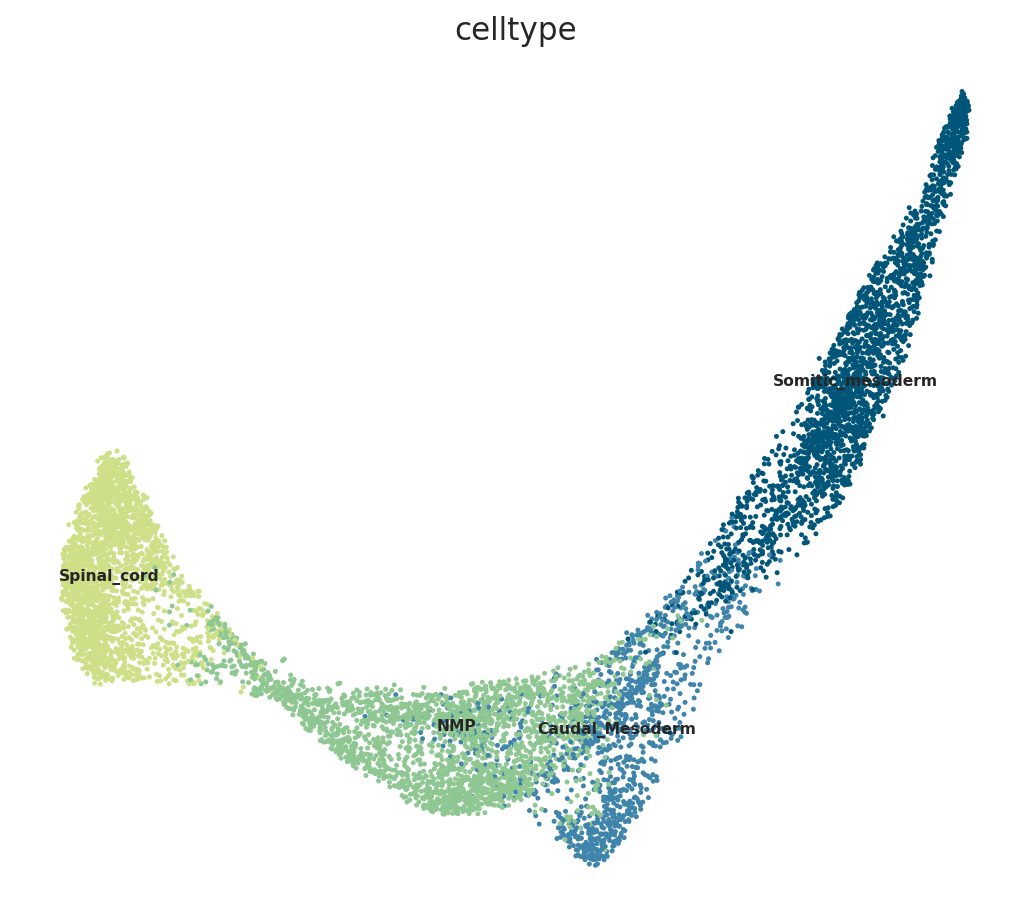

In [58]:
sc.pl.draw_graph(adata, color=["celltype"], size=20, legend_loc='on data', legend_fontsize=7)

In [102]:
adata.obs["Sox2_T"] = sc.get.obs_df(adata, keys=["ENSMUSG00000074637"]).values * sc.get.obs_df(adata, keys=["ENSMUSG00000062327"]).values

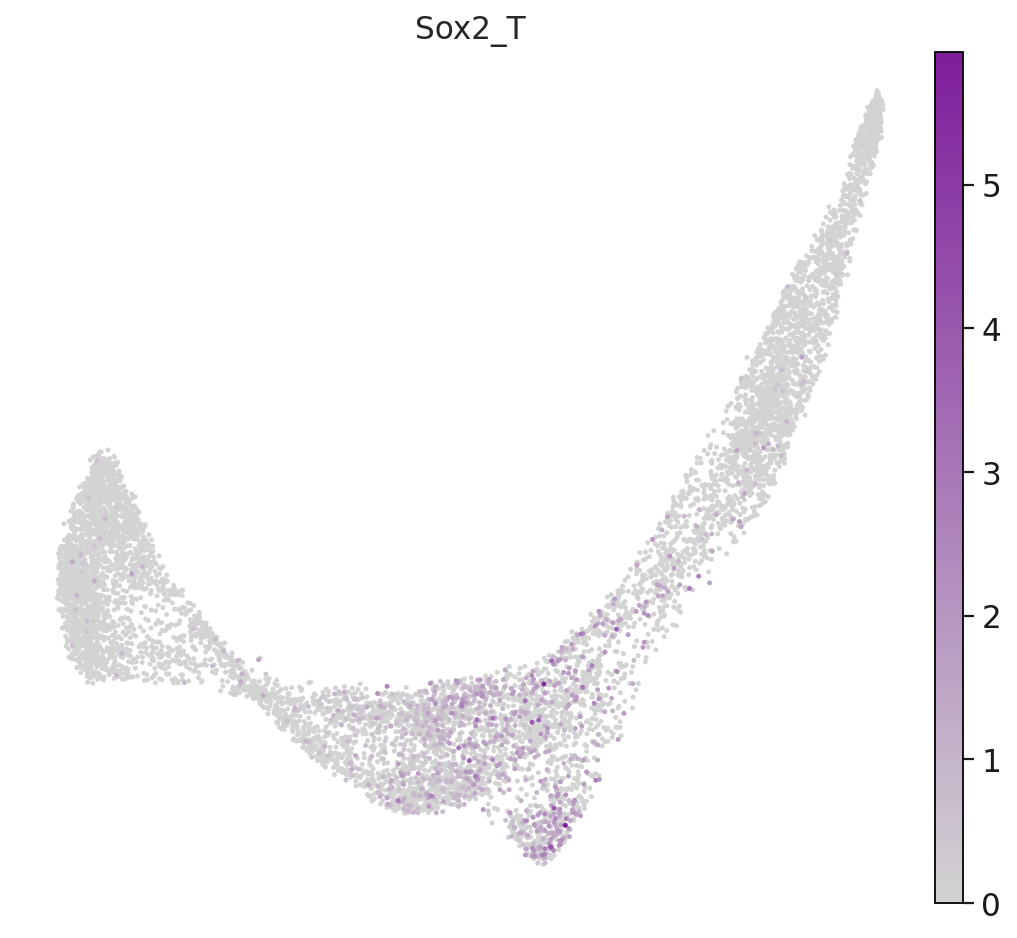

In [108]:
#sc.pl.draw_graph(adata, color=["Sox2_T"], size=20, cmap=sns.cubehelix_palette(dark=0, light=.9, as_cmap=True))
sc.pl.draw_graph(adata, color=["Sox2_T"], size=20, cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["purple"]], as_cmap=True))

In [59]:
adata.obsm

AxisArrays with keys: X_pca, X_pca_harmony, X_draw_graph_fa

## Metacells

In [60]:
model = SEACells.core.SEACells(adata, 
                  build_kernel_on = 'X_draw_graph_fa', 
                  n_SEACells = 200, 
                  n_waypoint_eigs = 10,
                  waypt_proportion = 1,
                  convergence_epsilon = 1e-7,
                  verbose = True)

# model.fit(n_iter=2)
model.fit()

Building kernel...
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/6990 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/6990 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/6990 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_draw_graph_fa
Computing diffusion components from X_draw_graph_fa for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 195 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/15 [00:00<?, ?it/s]

Selecting 5 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.18883562330162687
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Converged after 10 iterations.


Model Convergence

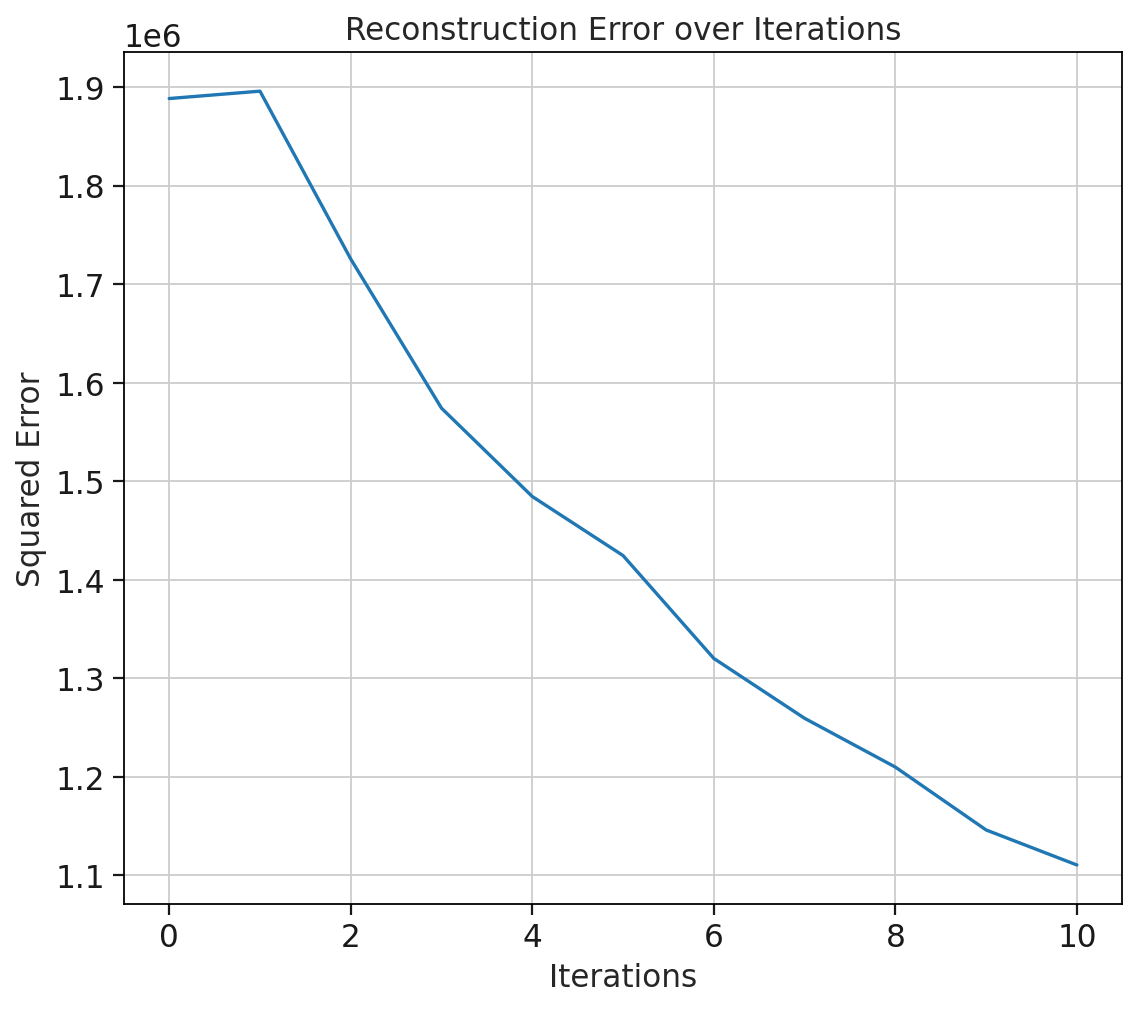

In [61]:
model.plot_convergence()

SEACell Assignments


In [62]:
adata.obs[['SEACell']].head()

,SEACell
index,
cell_100002,cell_70573
cell_100003,cell_37660
cell_100008,cell_37640
cell_100013,cell_23843
cell_100014,cell_98954


Summarizing data


In [63]:
# adata_metacells = SEACells.core.summarize_by_SEACell(adata, SEACells_label='SEACell', summarize_layer='raw')
# adata_metacells

Visualise Results            

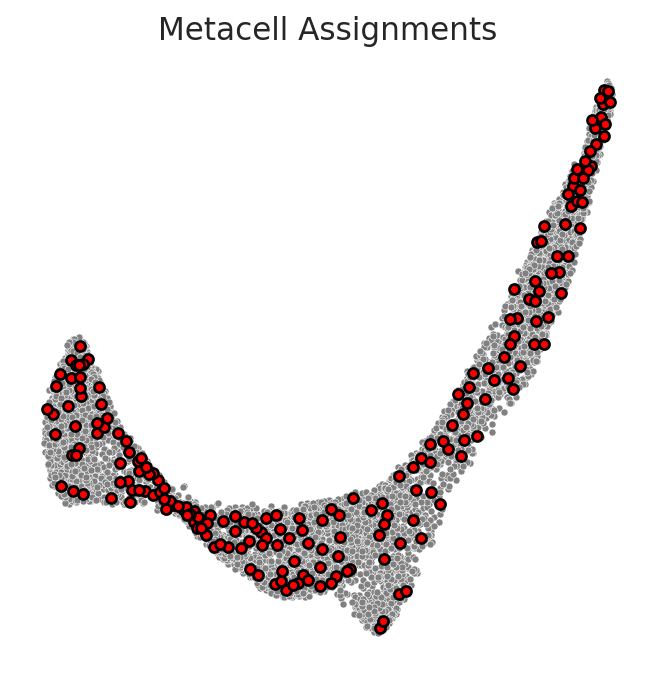

In [64]:
SEACells.plot.plot_2D(adata, key='X_draw_graph_fa', colour_metacells=False)

Save assignments

In [65]:
outfile = io["outdir"] / "cell2metacell_assignment.txt.gz"

In [66]:
to_save = adata.obs[['SEACell']].reset_index()
to_save.columns = ["cell","metacell"]
to_save.to_csv(outfile, sep="\t", header=True, index=False)

## Aggregate counts per metacell and plot trajectory at the metacell levevl

In [81]:
adata_metacells = SEACells.core.summarize_by_SEACell(adata, SEACells_label='SEACell', summarize_layer='raw')

  0%|          | 0/200 [00:00<?, ?it/s]

In [82]:
adata_metacells.X.todense()

matrix([[  1., 193.,  52., ...,   5.,  22.,   0.],
        [  0., 269.,  55., ...,   6.,  32.,   0.],
        [  0.,  39.,  11., ...,   1.,   4.,   0.],
        ...,
        [  0.,  60.,  14., ...,   2.,   4.,   0.],
        [  0.,  42.,  13., ...,   0.,   3.,   0.],
        [  0.,  41.,  13., ...,   0.,   4.,   0.]], dtype=float32)

In [83]:
adata_metacells.uns = adata.uns

In [84]:
adata_metacells.obs = (adata.obs.loc[adata_metacells.obs.index] >> 
    select(["sample","celltype"])
)

In [85]:
sc.pp.normalize_total(adata_metacells)
sc.pp.log1p(adata_metacells)

In [86]:
sc.pp.highly_variable_genes(adata_metacells, n_top_genes=1000)
sc.tl.pca(adata_metacells, n_comps=10)
sc.pp.neighbors(adata_metacells, n_neighbors=15, use_rep='X_pca')
sc.tl.draw_graph(adata_metacells, layout="fa", init_pos=None)

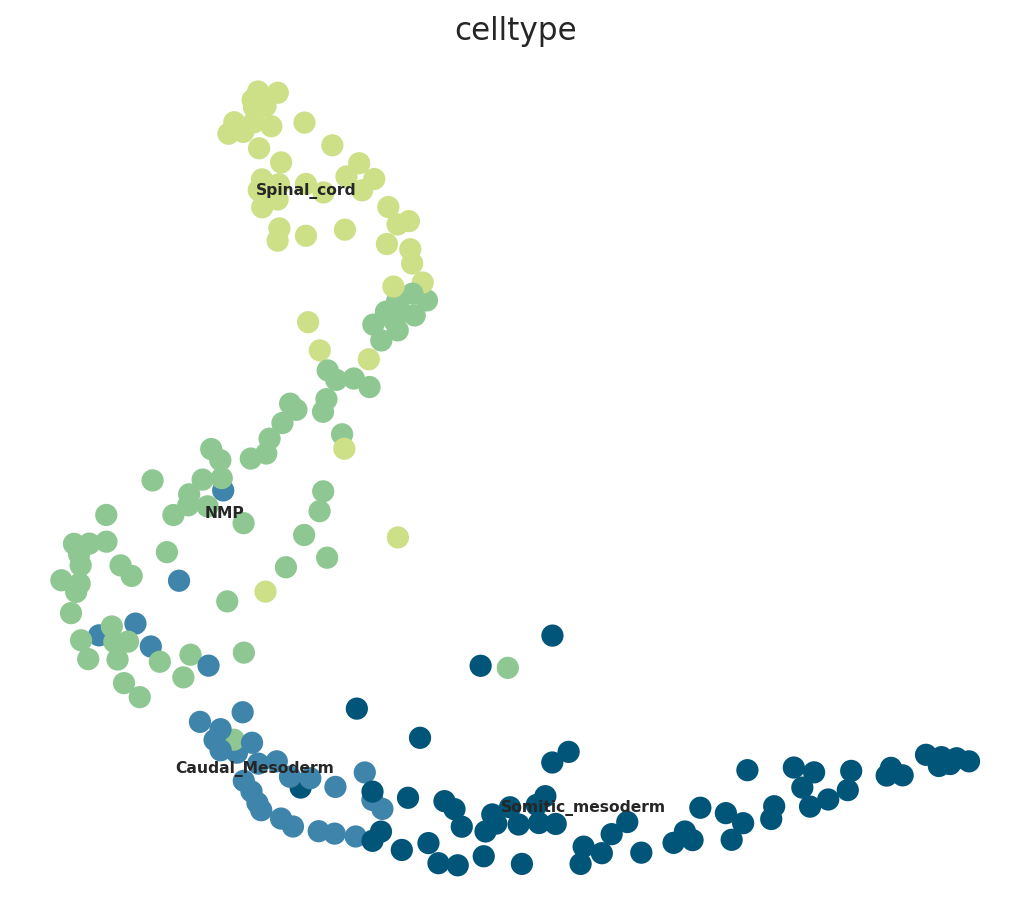

In [90]:
sc.pl.draw_graph(adata_metacells, color=["celltype"], size=400, legend_loc='on data', legend_fontsize=7)

In [92]:
adata_metacells.var

,highly_variable,means,dispersions,dispersions_norm
ENSMUSG00000025902,False,0.391200,0.427526,0.805499
ENSMUSG00000033845,False,4.656675,0.413018,-0.578563
ENSMUSG00000025903,False,3.260750,0.483410,-0.161193
ENSMUSG00000033813,False,3.572582,0.561800,-0.158970
ENSMUSG00000002459,False,0.292659,0.309997,0.382790
...,...,...,...,...
ENSMUSG00000061654,False,0.144112,-0.112447,-1.136575
ENSMUSG00000079834,False,0.066654,0.093997,-0.394077
ENSMUSG00000095041,False,1.132487,0.165790,-0.539470
ENSMUSG00000063897,False,2.408804,0.178759,-0.591734


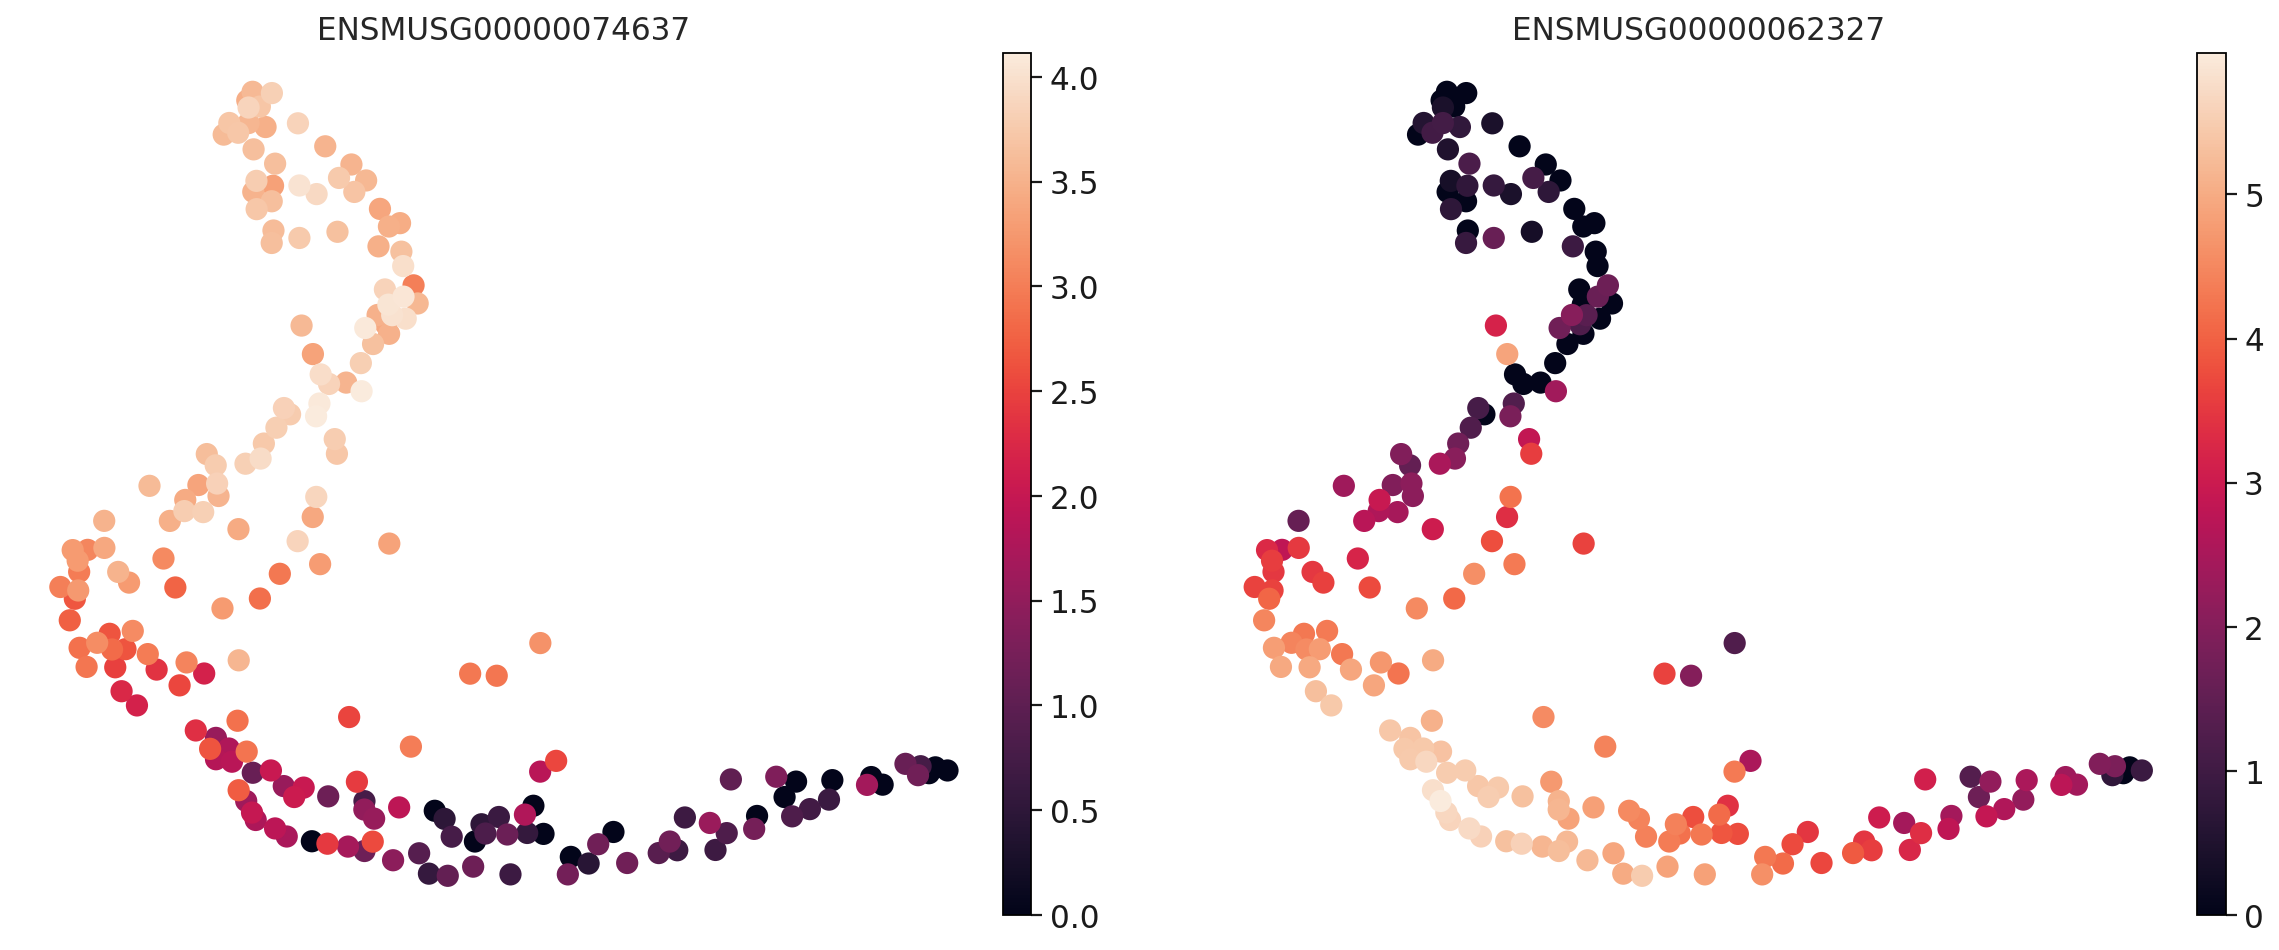

In [93]:
sc.pl.draw_graph(adata_metacells, color=["ENSMUSG00000074637","ENSMUSG00000062327"], size=400)

In [100]:
adata_metacells.obs["Sox2_T"] = sc.get.obs_df(adata_metacells, keys=["ENSMUSG00000074637"]).values * sc.get.obs_df(adata_metacells, keys=["ENSMUSG00000062327"]).values

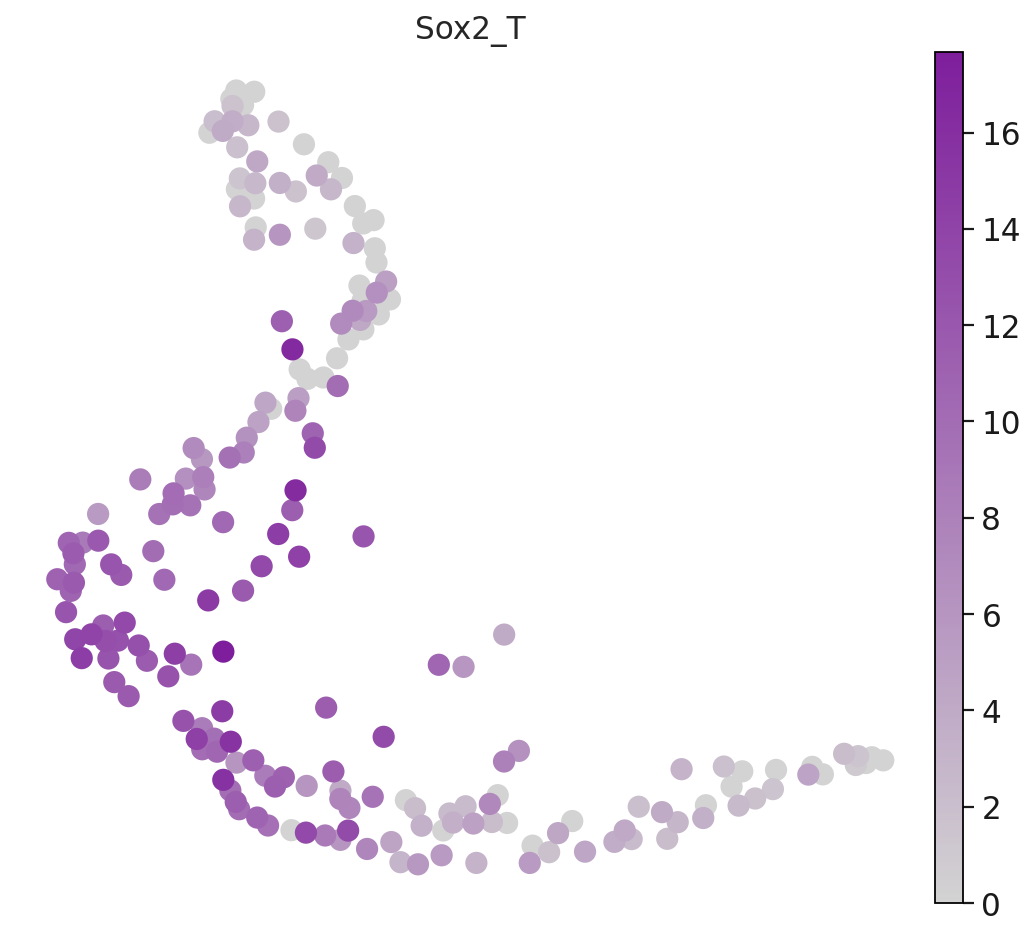

In [109]:
sc.pl.draw_graph(adata_metacells, color=["Sox2_T"], size=400, cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["purple"]], as_cmap=True))

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

Save metacell trajectory

In [65]:
outfile = io["outdir"] / "metacell_trajectory.txt.gz"

In [66]:
to_save = adata.obs[['SEACell']].reset_index()
to_save.columns = ["cell","metacell"]
to_save.to_csv(outfile, sep="\t", header=True, index=False)